<a href="https://colab.research.google.com/github/cecileloge/cs224v-truthsleuth-trendbender/blob/main/notebooks/%5BCS224V%5D_Truth_Sleuth_AI_for_YouTube_%7C_Fact_Checking_Samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Truth Sleuth AI: Fact-Checker Agent for YouTube Videos**
**Cecile Loge ep. Baccari** | ceciloge@stanford.edu | cecileloge@google.com \\
**Mohammad Rehan Ghori** | rghori@stanford.edu | rehang@google.com \\


---

**Motivation:** Misinformation is one of the most pressing threats of our time, and YouTube videos serve as a major platform through which it can spread [1]. Providing fact-checked information to address misleading content has been shown to be more effective than simply removing it [2].

**Project:** Can we build an application that takes a YouTube video as input and not only generates a list of the main claims made in the video but also fact-checks them?

---

* [1] An open letter to YouTube’s CEO from the world’s fact-checkers (on poynter.org), 2022. \\
* [2] Ecker, Ullrich KH, et al. "The effectiveness of short‐format refutational fact‐checks." British journal of psychology 111.1 (2020): 36-54.

---
## **Setting Up Everything**
Choosing the YouTube video url, and installing/importing libraries.

---

In [ ]:
# Provide the video url
VIDEO_URL = "https://www.youtube.com/watch?v=ssqucRUoRjs"

In [ ]:
# Install & Import Libraries

# Youtube Extractors
!pip install youtube-transcript-api
!pip install pytube
!pip install -U yt-dlp
!apt install ffmpeg
from youtube_transcript_api import YouTubeTranscriptApi
from pytube import extract

# Assembly AI
!pip install assemblyai
import assemblyai as aai

# Data & Tools
import pandas as pd
from google.colab import userdata
from PIL import Image
import json
import os
current_dir = os.getcwd()
from datetime import datetime, date
import time

# Google API
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# Markdown for the final output
from IPython.display import display, Markdown, Latex
import textwrap

# Gemini API
!pip install -q -U google-generativeai
import google.generativeai as genai
from google.colab import userdata

# LangChain Prompting
!pip install langchain
from langchain import PromptTemplate

# For Web Scraping
!pip install requests
!pip install beautifulsoup4
!pip install wikipedia
from bs4 import BeautifulSoup
import requests
import wikipedia
import googlesearch as g

In [ ]:
# YouTube API Key (Google for Developers Platform)
DEVELOPER_KEY=userdata.get('DEVELOPER_KEY')

# Google Developer API Key for GenAI
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel(model_name="gemini-1.5-flash")
GEM_SAFETY_SETTINGS = [
    {
      "category": "HARM_CATEGORY_HARASSMENT",
      "threshold": "BLOCK_NONE"
    },
    {
      "category": "HARM_CATEGORY_HATE_SPEECH",
      "threshold": "BLOCK_NONE"
    },
    {
      "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
      "threshold": "BLOCK_NONE"
    },
    {
      "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
      "threshold": "BLOCK_NONE"
    }
    ]

# Assembly AI API Key
AAI_API_KEY = userdata.get('AAI_API_KEY')
aai.settings.api_key = AAI_API_KEY

In [ ]:
# Prompt Templates
!mkdir prompts
!curl -L -o prompts/reformat.prompt "https://drive.google.com/uc?export=download&id=1aykUMXxUR1gWOil5X83aF7aem1s5rjIT"
!curl -L -o prompts/claims.prompt "https://drive.google.com/uc?export=download&id=1AlKLI-IP05jMps4Ol7BN2RPcmAMH2H-J"
!curl -L -o prompts/factcheck.prompt "https://drive.google.com/uc?export=download&id=1cevbk44t7ZWJr3rwpu-b1ncqHYdq-p8x"

mkdir: cannot create directory ‘prompts’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   224  100   224    0     0     81      0  0:00:02  0:00:02 --:--:--    96
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  8614  100  8614    0     0   3436      0  0:00:02  0:00:02 --:--:--  8562
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4630  100  4630    0     0   1590      0  0:00:02  0:00:02 --:--:--  368

---
## **STEP 1 | Extracting info & audio from Video URL**

Functions to process a video from a provided YouTube link. Should output a text transcript from the audio - along with descriptions of the video (title, author, tags) and a summary of the comments.

---

In [ ]:
def get_comments(video_id):
  """
  Function to get top 100 comments from a YouTube video.
  Saves them into comments.csv. Returns a panda dataframe.
  """
  youtube = build("youtube", "v3", developerKey=DEVELOPER_KEY)

  try:
    # Retrieve comment thread using the youtube.commentThreads().list() method
    response = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,
        order="relevance"
    ).execute()

    comments = []
    for item in response["items"]:
      comment_text = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
      likes = item["snippet"]["topLevelComment"]["snippet"]["likeCount"]
      comments.append({"comment": comment_text, "num_of_likes": likes})

      #if 'nextPageToken' in response:
      #  response = youtube.commentThreads().list(
      #      part="snippet",
      #      videoId=video_id,
      #      maxResults=100,
      #      order="relevance"
      #      pageToken = response['nextPageToken']
      #  ).execute()
      #else:
      #  break
      comments_df = pd.DataFrame(comments).sort_values(by=['num_of_likes'], ascending=False)
      comments_df.to_csv("comments.csv", index=False)
    return comments_df
  except HttpError as error:
    print(f"An HTTP error {error.http_status} occurred:\n {error.content}")
    return None

In [ ]:
def get_video_details(video_id):
  """
  Function to get details from a YouTube video.
  Returns a tuple for title, channel, tags, views, likes.
  """
  youtube = build('youtube', 'v3', developerKey=DEVELOPER_KEY)
  request = youtube.videos().list(part='snippet,statistics', id=video_id)
  details = request.execute()
  thumbnail_url = details['items'][0]['snippet']['thumbnails']['high']['url']
  channel = details['items'][0]['snippet']['channelTitle']
  title = details['items'][0]['snippet']['title']
  tags = details['items'][0]['snippet'].get('tags')
  likes = int(details['items'][0]['statistics']['likeCount'])
  views = int(details['items'][0]['statistics']['viewCount'])
  videodate = details['items'][0]['snippet']['publishedAt']
  return channel, title, tags, likes, views, thumbnail_url, videodate


In [ ]:
def get_captions(video_url, video_id):
  """
  Function to get audio captions in 'en' (English) from a YouTube video.
  Either from the YouTube subtitles if they exist, or from Assembly AI.
  Uses Gemini to format the raw audio captions, and returns a string.
  """
  try:
    yt = YouTubeTranscriptApi.get_transcript(video_id, languages=['en'])
    captions = ''
    for i in yt:
      captions += i['text']+" "
  except Exception as e:
    print(f"Error: {e}")
    print(f"Using Assembly AI instead...")
    !yt-dlp --get-url -f bestaudio $VIDEO_URL > audio.txt
    with open('audio.txt', 'r') as file:
      AUDIO_URL = file.read()
    config = aai.TranscriptionConfig(auto_highlights=True)
    transcriber = aai.Transcriber()
    transcript = transcriber.transcribe(AUDIO_URL, config)
    captions = transcript.text

  # Using Gemini to format the raw audio captions
  with open("prompts/reformat.prompt", "r") as f:
    text = f.read()
  prompt_template = PromptTemplate.from_template(template=text, template_format="jinja2")
  prompt: str = prompt_template.format(captions=captions)
  response = model.generate_content(prompt, safety_settings=GEM_SAFETY_SETTINGS)
  audio_captions_formatted = response.text

  return audio_captions_formatted

---
## **STEP 2 | Extracting the claims to fact-check from Video audio**

Functions to extract the top claims made in the video. We will be using Google's Gemini with robust prompt engineering - leveraging the LangChain library.

---

In [ ]:
def extract_claims(video_url):
  """
  Function to extract the top claims that should be fact-checked.
  Uses Gemini with the claims.prompt prompt.
  Returns a tuple with: title, channel, thumbnail_url,
      and a json object with fields 'claim', 'questions', 'passage', 'relevance'
  """
  video_id = extract.video_id(video_url)
  channel, title, _, _, _, thumbnail_url, videodate = get_video_details(video_id)
  videodate = datetime.strptime(videodate[:10], '%Y-%m-%d').strftime("%Y-%m-%d")
  audio_captions_formatted = get_captions(video_url, video_id)

  # Using the prompt template and calling Gemini
  with open("prompts/claims.prompt", "r") as f:
    text = f.read()

  prompt_template = PromptTemplate.from_template(template=text, template_format="jinja2")
  claims_prompt: str = prompt_template.format(
      todaydate=date.today().strftime("%Y-%m-%d"),
      videodate=videodate,
      channel=channel,
      title=title,
      captions=audio_captions_formatted,
      )
  response = model.generate_content(claims_prompt, safety_settings=GEM_SAFETY_SETTINGS)

  json_promt = "Make sure the following text can be read directly by json.loads(): <<< " + response.text + " >>>. '\
  Don't output anything else than your version of the text."
  response = model.generate_content(json_promt, safety_settings=GEM_SAFETY_SETTINGS)
  claims = json.loads(response.text[8:-4])

  return title, channel, thumbnail_url, claims

---
## **STEP 3 | Fact-checking the claims by cross-checking reliable sources**

Cross-reference claims with reliable sources, and classify claims into true, unsure and false (ideally with links / sources).


This step leverages the Google FactCheck Claim Search API, the Wikipedia API and the Google Search API.

The LLM is called several times throughout this step via robust prompt engineering to interpret, cross-reference, and ultimately classify the claims.  

---

In [ ]:
# Our reliable sources for Fact-Checking
# 1 - Google Fact-Check API
GOOGLE_FACT_CHECK_API_KEY = userdata.get('GFC_API_KEY')
GOOGLE_FACT_CHECK_URL = 'https://factchecktools.googleapis.com/v1alpha1/claims:search'

# 2 - Wikipedia
wikipedia.set_lang('en')

# 3 - Google Search
GOOGLE_USER_AGENT = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36"

In [ ]:
def call_googlefacts(claim):
  """
  Function to call the Google Fact Check API
  Returns the claim reviews in the Claim Review structured format
  https://developers.google.com/search/docs/appearance/structured-data/factcheck
  """

  params = {
      'query': claim,
      'key': GOOGLE_FACT_CHECK_API_KEY
  }
  response = requests.get(GOOGLE_FACT_CHECK_URL, params=params)
  if response.status_code == 200:
      data = response.json()
      return data.get('claims', [])
  else:
      return None

def check_googlefacts(claim):
  """
  Function to process the Google Fact Check claim reviews
  Returns a string = concatenation of relevant results
  """
  results = call_googlefacts(claim)
  summary = ''
  if results:
      for i, r in enumerate(results):
          source = r.get('claimReview', [{}])[0].get('publisher').get('name')
          url = r.get('claimReview', [{}])[0].get('url')
          claimant = r.get('claimant')
          date = r.get('claimDate')
          text = r.get('text')
          truthfulness = r.get('claimReview', [{}])[0].get('textualRating')
          summary += f"Source #{i+1}: {source} at {url}.\n     Claimant: {claimant}\n     Description: {text}\n     Truthfulness: {truthfulness}\n\n"

  return summary

def check_googlesearch(claim, limit=2):
  """
  Function to call the Google Search API
  Calls Gemini to process the results and generate a summary
  Returns a string = concatenation of relevant results
  """
  urls = list(g.search(claim, stop=limit, lang='en'))
  headers = {"user-agent": GOOGLE_USER_AGENT}
  summary = ''
  for url in urls:
    session = requests.Session()
    website = session.get(url, headers=headers)
    web_soup = BeautifulSoup(website.text, 'html.parser')
    summary_promt = "I need you to give me the key information contained in a specific webpage article. I will provide you with html code. '\
    Do not describe the webpage or the article. Focus on extracting the key claims, and summarizing the information the page is giving in a precise, comprehensive yet concise way. '\
    Your answer should ideally help answer the question: " + claim + ".\n'\
    HTLM Code: <<< " + str(web_soup) + " >>>"
    retry_count = 0
    while retry_count < 3:
      try:
         response = model.generate_content(summary_promt, safety_settings=GEM_SAFETY_SETTINGS)
         summary += f"Source: {url}.\nDescription: {response.text}\n"
         retry_count = 3
      except Exception as e:
         time.sleep(2)
      retry_count += 1
    session.close()
  return summary

def check_wikipedia(claim):
  """
  Function to call the Wikipedia API and process the results
  Returns a string = concatenation/summary of relevant Wikipedia articles
  """
  summary = ''
  search_results = wikipedia.search(claim)
  for r in search_results[:2]:
    try:
      call = wikipedia.page(r)
      summary += f"From the \"{r}\" Wikipedia page ({call.url}): "+ call.content +"\n\n"
    except wikipedia.exceptions.DisambiguationError:
      summary += ''
    except wikipedia.exceptions.PageError:
      summary += ''
    except wikipedia.exceptions.WikipediaException:
      summary += ''
    except Exception:
      summary += ''
  return summary

In [ ]:
def get_claim_summary(claim, questions):
  """
  Function to get the final say on a specific claim.
  Calls Gemini with the factcheck.prompt prompt.
  Returns json object with fields: `claim`, `verdict`, `reason`, `sources`.
  """
  summary_gfc = ''
  summary_search = ''
  for q in questions:
    gfc = check_googlefacts(q)
    if gfc:
      summary_gfc += gfc + "\n"
  for q in questions:
    search = check_googlesearch(q)
    summary_search += search + "\n"
  summary_wiki = check_wikipedia(claim)

  with open("prompts/factcheck.prompt", "r") as f:
        text = f.read()
  prompt_template = PromptTemplate.from_template(template=text, template_format="jinja2")
  fact_check_prompt: str = prompt_template.format(
      claim=claim,
      report_GFC=summary_gfc + "\n" + summary_search,
      report_wiki=summary_wiki,
      )

  retry_count = 0
  while retry_count < 3:
      try:
         response = model.generate_content(fact_check_prompt, safety_settings=GEM_SAFETY_SETTINGS)
         return response.text
      except Exception as e:
         #print(f"Error: {e}")
         time.sleep(2)
      retry_count += 1
  return None

---
## **TRUTH SLEUTH AGENT | Putting it all together & Generating the Fact-Check Report**

Generating the final report, leveraging Markdown for formatting. Option to skip printing the "Unsure" claims.

---


In [ ]:
def generate_report(video_url, skip_unsure = True):

  # Extracting the claims
  title, channel, thumbnail_url, claims = extract_claims(video_url)

  # Formatting
  color = {"question": "black", "true": "MediumSpringGreen", "partly true": "LightGreen", "partly false": "lightcoral", "false": "red", "unsure": "grey"}
  capped = {"true": "TRUE", "partly true": "PARTLY TRUE", "partly false": "PARTLY FALSE", "false": "FALSE", "unsure": "UNSURE"}
  delimiter = "\n"+"_"*100+"\n"

  # Generating Report Header
  thumb = Image.open(requests.get(thumbnail_url, stream=True).raw)
  formatted_title1 = f"<font size='+2' color='Bisque'><blockquote>📓📓 🔍 **TRUTH SLEUTH FACT-CHECK REPORT** 🔍 📓📓</blockquote></font>"
  formatted_title2 = f"<font size='+2' color='white'><blockquote>**{title}** by {channel}</blockquote></font>"
  display(Markdown(formatted_title1 + formatted_title2))
  display(thumb)

  # Getting each claim's verdict + Formatting again
  for i, c in enumerate(claims["claims"]):
    text = get_claim_summary(c['claim'], c['questions'])
    if text == None:
      continue
    text = text.replace("$", "USD ")

    try:
      verdict = json.loads(text)
    except json.JSONDecodeError:
      verdict = json.loads(text[8:-4])
    if (verdict.get('verdict') == "unsure" and skip_unsure):
      continue

    formatted_claim = f"<font size='+1' color='white'><blockquote>**• {c['claim']}**</blockquote></font>"
    formatted_verdict = f"<font size='+1' color='{color[verdict.get('verdict')]}'><blockquote>**{capped[verdict.get('verdict')]}**\n\n</blockquote></font>"
    links = ""
    for l in verdict.get('sources'):
      links += "\n\n• " + l
    display(Markdown(delimiter + formatted_claim+formatted_verdict+verdict.get('reason')+links))
  display(Markdown(delimiter))

  return None

<font size='+2' color='Bisque'><blockquote>📓📓 🔍 **TRUTH SLEUTH FACT-CHECK REPORT** 🔍 📓📓</blockquote></font><font size='+2' color='white'><blockquote>**How To MAKE Sure Women AREN'T Useless To You!** by FreshandFit</blockquote></font>

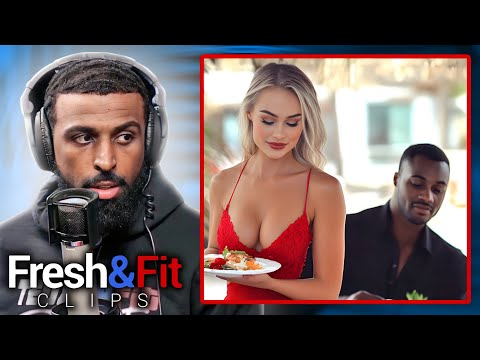


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Men should treat women as subordinates in relationships.**</blockquote></font><font size='+1' color='red'><blockquote>**FALSE**

</blockquote></font>The claim promotes a harmful and outdated view of relationships.  Treating women as subordinates in relationships is a form of discrimination and violence, which is unacceptable in modern society.

• https://en.wikipedia.org/wiki/Domestic_violence

• https://en.wikipedia.org/wiki/Violence_against_women


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Women are not equal to men.**</blockquote></font><font size='+1' color='red'><blockquote>**FALSE**

</blockquote></font>The provided information asserts that men and women are equally human, with biological differences, and are deserving of equal treatment and opportunities. Both the UN and Wikipedia emphasize the need for gender equality, not making men and women the same, but ensuring equal opportunities.

• https://www.unfpa.org/resources/frequently-asked-questions-about-gender-equality.

• https://en.wikipedia.org/wiki/All_men_are_created_equal


____________________________________________________________________________________________________


In [ ]:
generate_report(VIDEO_URL, True)

---
## **EXAMPLES | Sample Outputs**

---

<font size='+2' color='Bisque'><blockquote>📓📓 🔍 **TRUTH SLEUTH FACT-CHECK REPORT** 🔍 📓📓</blockquote></font><font size='+2' color='white'><blockquote>**6 Garlic Benefits for Acne. How to Use Garlic to  Heal Acne: Topically & Internally** by ComfortLifeChannel</blockquote></font>

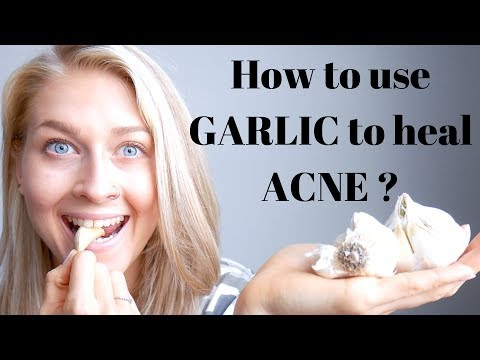


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Applying raw garlic directly to the face can be irritating and even burn the skin.**</blockquote></font><font size='+1' color='MediumSpringGreen'><blockquote>**TRUE**

</blockquote></font>Applying garlic topically to the skin can cause irritation and even burning, due to its strong properties. It is recommended to consult a dermatologist before applying garlic to the skin, especially if you have sensitive skin.

• https://www.medicalnewstoday.com/articles/garlic-for-acne


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Garlic contains allicin, a compound with antifungal, antibacterial, and antiseptic properties that can help kill acne-causing bacteria when applied topically or consumed internally.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>Allicin in garlic has been shown to possess antibacterial properties, including against acne-causing bacteria. However, while there is research suggesting potential benefits, there is no direct research on its effectiveness as an acne treatment.

• https://www.medicalnewstoday.com/articles/garlic-for-acne/

• https://pubmed.ncbi.nlm.nih.gov/10594976/

• https://www.stanfordchildrens.org/en/topic/default?id=garlic-19-Garlic.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Garlic can help dry out acne due to its sulfur compound.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>The provided information talks about the potential of garlic for acne treatment due to its antibacterial and anti-inflammatory properties. However, it doesn't specifically mention drying out acne. It focuses on reducing inflammation and redness.

• https://www.vinmec.com/eng/article/how-to-treat-acne-with-garlic-is-good-en.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Garlic can reduce inflammation and redness associated with acne due to its anti-inflammatory properties.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>While the provided information states that garlic contains anti-inflammatory properties, it doesn't specifically state that it can reduce inflammation and redness associated with acne. Therefore, the claim is not supported by the provided evidence.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Garlic can be used topically to treat acne scars by mixing half a garlic clove with one tablespoon of honey and applying it directly to the scar for five minutes.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>While the provided information suggests that garlic can be used topically to treat acne, it does not specifically address acne scars. Therefore, we cannot confirm or deny the claim's validity.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Garlic can help boost the immune system, potentially reducing acne breakouts.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>While garlic is believed to have antiviral and antimicrobial properties, the provided information does not specifically address its effects on the immune system or acne. Further research is needed to substantiate these claims.

• https://www.urmc.rochester.edu/encyclopedia/content.aspx?contenttypeid=19&contentid=Garlic.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Garlic is a powerful antioxidant that can help fight free radicals in the skin.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>The provided study shows that aged garlic has stronger antioxidant properties than fresh garlic, including a higher ability to scavenge free radicals. While this doesn't directly mention skin, it suggests that garlic can be a source of antioxidants that contribute to fighting free radicals.

• https://pmc.ncbi.nlm.nih.gov/articles/PMC6049750/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Garlic can promote clearer and brighter skin by increasing the skin's healing properties.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>While garlic has been studied for its potential dermatological benefits, including wound healing, the claim that it promotes clearer and brighter skin is not fully supported by the provided information. The study focuses on garlic's overall benefits for skin health, not specifically its effect on skin clarity or brightness.

• https://pmc.ncbi.nlm.nih.gov/articles/PMC4211483/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• The best way to use garlic for acne is to consume it internally due to its beneficial properties.**</blockquote></font><font size='+1' color='red'><blockquote>**FALSE**

</blockquote></font>There is no scientific evidence to support the claim that eating garlic can cure acne. While garlic has potential health benefits, experts recommend a balanced diet and suggest consulting a dermatologist if acne persists.

• https://www.verywellhealth.com/can-eating-raw-garlic-daily-get-rid-of-acne-8666139


____________________________________________________________________________________________________


In [ ]:
# 6 Garlic Benefits for Acne. How to Use Garlic to Heal Acne: Topically & Internally by ComfortLifeChannel
# https://www.youtube.com/watch?v=0lhY4sPSgNo

<font size='+2' color='Bisque'><blockquote>📓📓 🔍 **TRUTH SLEUTH FACT-CHECK REPORT** 🔍 📓📓</blockquote></font><font size='+2' color='white'><blockquote>**Andrew Wilson LECTURES Feminist That Can't Accept The TRUTH!** by whatever Clips</blockquote></font>

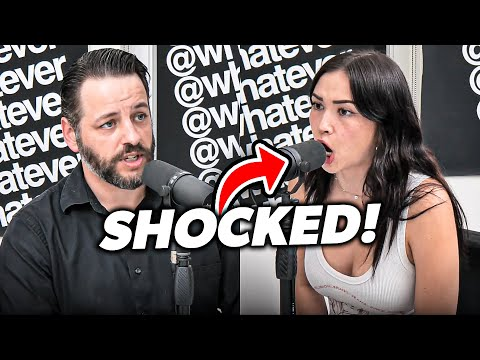


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Women initiate the majority of divorces.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>While women do initiate a larger proportion of divorces in several countries, including the United States, the UK, and South Africa, this trend is not universal. For example, in Japan, divorce by agreement is the most common type, indicating a more equal level of initiation.

• https://en.wikipedia.org/wiki/Divorce

• https://en.wikipedia.org/wiki/Divorce_of_same-sex_couples

• https://en.wikipedia.org/wiki/South_Africa


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Women leaving marriages is not primarily driven by abuse or abandonment by men.**</blockquote></font><font size='+1' color='lightcoral'><blockquote>**PARTLY FALSE**

</blockquote></font>While women may leave marriages for various reasons, including dissatisfaction, personal growth, and independence, evidence from divorce lawyers and fact-checking websites shows that abuse, addiction, and other issues in men are frequent causes of women initiating divorce.

• https://divorce.com/blog/og_blog_img/who-initiates-divorce-more.jpg?sa=X&ved=2ahUKEwifxv3P9rWJAxV0STABHUuyGv0Q_B16BAgGEAI.

• https://www.quora.com/I-am-not-saying-anything-bad-about-women-but-do-most-of-them-leave-their-husbands-just-because-they-found-someone-slightly-better.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Feminism is the root cause of a variety of societal problems, including increased mental illness in children, the need for two-income households, and higher divorce rates.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>While the provided information discusses the impact of patriarchy on mental health and the rise of two-income households, it does not directly address feminism as the root cause of these societal problems. Therefore, it is not possible to determine the truthfulness of the claim based solely on the provided information.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Women are more likely to prioritize their own happiness over the well-being of their children.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>The provided information does not directly address the claim. The provided Google Fact Check source asserts that parents need to prioritize their own happiness to be good parents, while the Wikipedia extract discusses well-being factors, including the impact of gender, but does not provide a comparison between men and women on prioritizing their happiness versus their children's well-being.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• A large proportion of children from single-parent households experience mental illness.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>The provided information does not specify a proportion of children from single-parent households who experience mental illness. While the information states that children from single-parent households are at a higher risk of developing mental health issues, it does not provide specific statistics to support the claim.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Feminism is driven by a subjectivist worldview, rather than an empathetic one.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>The provided information is insufficient to determine whether feminism is driven by a subjectivist or empathetic worldview. While one source asserts that feminism is based on objective values, another lacks relevant information.

• https://www.quora.com/Is-feminism-a-subjective-theory-movement.

• https://scholarship.claremont.edu/cgi/viewcontent.cgi?article=1063&context=pitzer_fac_pub


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Feminism is ultimately incoherent and doesn't make sense.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>The provided information does not contain an expert report on the coherence or incoherence of feminism. While some criticisms of feminism are presented, the lack of expert analysis makes a conclusive verdict impossible.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• The patriarchy is the root cause of feminism.**</blockquote></font><font size='+1' color='red'><blockquote>**FALSE**

</blockquote></font>Feminism is a multifaceted movement with goals beyond simply reacting to the patriarchy. While patriarchy contributes to the oppression of women, feminism also seeks gender equality, recognition of women's rights, and the dismantling of harmful stereotypes.

• https://e1.nmcdn.io/pmc/wp-content/uploads/2023/09/EndThePatriarchy.png/v:1-width:1200-height:630-fit:cover/EndThePatriarchy.png?signature=39e81123&sa=X&ved=2ahUKEwiF-5iV97WJAxUPSzABHbASI34Q_B16BAgKEAI.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Women are not capable of enforcing their will through physical force.**</blockquote></font><font size='+1' color='red'><blockquote>**FALSE**

</blockquote></font>The provided information does not directly address the claim. However, it does mention numerous examples of women in law enforcement roles, including those who have been promoted to high-ranking positions within their respective agencies. This indicates that women are capable of exerting physical force in these roles, which contradicts the claim.

• https://en.wikipedia.org/wiki/Women_in_law_enforcement


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Women are reliant on men for protection.**</blockquote></font><font size='+1' color='red'><blockquote>**FALSE**

</blockquote></font>The claim that women are reliant on men for protection is a generalization that has been debunked by many experts. It ignores the fact that women are capable of protecting themselves and that they are not inherently vulnerable.

• https://www.quora.com/People-expect-men-to-protect-women-but-what-are-women-expected-to-do-for-men-in-return.


____________________________________________________________________________________________________


In [ ]:
# Andrew Wilson LECTURES Feminist That Can't Accept The TRUTH! by whatever Clips
# https://www.youtube.com/watch?v=sFXrbxi62sY

<font size='+2' color='Bisque'><blockquote>📓📓 🔍 **TRUTH SLEUTH FACT-CHECK REPORT** 🔍 📓📓</blockquote></font><font size='+2' color='white'><blockquote>**The 10 Foods You Should Never Eat!  | TKTS Clips** by The Kevin Trudeau Show</blockquote></font>

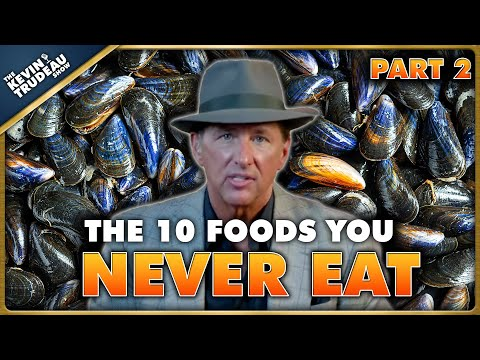


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Hydrogenated oils, also known as trans fats, can damage arteries, increase appetite, mess up hormone systems, and cause depression.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>The claim that hydrogenated oils, also known as trans fats, can damage arteries, increase appetite and contribute to depression is supported by the provided sources. However, there is no direct evidence on the effect of trans fats on hormone systems.

• https://medlineplus.gov/ency/patientinstructions/000786.htm

• https://www.medicalnewstoday.com/articles/hydrogentated-oil

• https://www.thegoodnewsdr.com/news/s4ppr1enc7o157p3bpki0rpgvdazc1.

• https://www.webmd.com/depression/ss/slideshow-avoid-foods-anxiety-depression


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Genetically modified organisms (GMOs) can cause a wide range of health problems, including gastrointestinal issues, bloating, colon problems, hormone imbalances, hunger, weight gain, cancer, and high blood pressure.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>While some studies have raised concerns about potential health effects of GMOs, particularly one study on pigs, the claim is too broad and lacks substantial evidence from human studies. Other research and regulatory agencies have found no evidence of GMOs causing the claimed health issues.

• https://www.todaysdietitian.com/newarchives/120913p12.shtml

• https://www.mdanderson.org/publications/focused-on-health/gmos-cancer.h15-1589046.html

• https://www.fda.gov/media/135280/download

• https://pubmed.ncbi.nlm.nih.gov/19326032/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Monosodium glutamate (MSG) can increase appetite, cause thirst, and lead to weight gain by increasing fat cell size.**</blockquote></font><font size='+1' color='lightcoral'><blockquote>**PARTLY FALSE**

</blockquote></font>While the provided information shows that MSG can promote fat deposition in adipose tissue and may influence the salience of protein cues, leading to a more robust satiety response, it does not confirm that it can increase appetite, cause thirst, or directly lead to weight gain.

• https://pmc.ncbi.nlm.nih.gov/articles/PMC4153311/

• https://www.ajinomoto.co.th/en/our-story/msg/stop-bullying-msg.

• https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6642617/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Most wheat consumed in North America is high in gluten and has not been fermented for 48 hours, leading to digestive issues, weight gain, and allergic reactions.**</blockquote></font><font size='+1' color='lightcoral'><blockquote>**PARTLY FALSE**

</blockquote></font>While most wheat consumed in North America is likely high in gluten, there is no evidence to support the claim that it is not fermented for 48 hours. Gluten intolerance can lead to digestive issues, but not weight gain. It can lead to weight loss due to nutrient absorption issues, which can result in vitamin deficiencies and inflammation in the gut.

• https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6396733/

• https://amfmcenter.com/blogposts/can-gluten-intolerance-lead-health-problems-weight-gain.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Soy, particularly from Monsanto seed, is genetically modified and can cause intestinal problems and lower testosterone levels.**</blockquote></font><font size='+1' color='lightcoral'><blockquote>**PARTLY FALSE**

</blockquote></font>The claim that soy from Monsanto seed is genetically modified is true, but the claim that it can cause intestinal problems and lower testosterone levels is not supported by the provided information.  The information provided shows that soy consumption may have a positive impact on gut health, although further research is recommended to confirm the effects of soy protein isolates and textured soy proteins.

• https://www.fda.gov/food/agricultural-biotechnology/gmo-crops-animal-food-and-beyond.

• https://pmc.ncbi.nlm.nih.gov/articles/PMC10144768/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Cornfed beef contains genetically modified corn and can lead to lower testosterone, antibiotic build-up, and disease.**</blockquote></font><font size='+1' color='lightcoral'><blockquote>**PARTLY FALSE**

</blockquote></font>The claim that cornfed beef contains genetically modified corn is likely true, but the claim that it can lead to lower testosterone, antibiotic build-up, and disease is not supported by the provided information. While the use of antibiotics in feedlots is mentioned, the connection to lower testosterone and disease is not discussed.

• https://nebraskacorn.gov/cornstalk/animals/grass-vs-grain-fed/

• https://wrongdirectionfarm.com/since-corn-is-a-grass-does-corn-fed-count-as-grass-fed/

• https://www.canr.msu.edu/news/there-s-hormones-in-beef-msu-extension-addresses-common-misconceptions/

• https://www.npr.org/sections/thesalt/2019/04/02/707406946/some-in-the-beef-industry-are-bucking-the-widespread-use-of-antibiotics-heres-ho.

• https://sevensons.net/grass-fed-vs-corn-fed-beef/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Homogenized dairy products can scar arteries, mess up hormones, and cause weight gain, digestive issues, and bloating.**</blockquote></font><font size='+1' color='lightcoral'><blockquote>**PARTLY FALSE**

</blockquote></font>While the process of homogenization has been linked to potential risks, the claim that it can 'scar arteries' is not supported by the provided information.  However, the presence of hormones in dairy products, particularly milk, has been associated with potential disruptions in endocrine systems and weight gain, though further research is needed to establish conclusive links.

• https://www.latimes.com/archives/la-xpm-1998-aug-10-he-11721-story.html.

• https://pmc.ncbi.nlm.nih.gov/articles/PMC4524299/

• https://www.quora.com/Does-homogenized-milk-make-you-fat


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Companies add monosodium glutamate (MSG) to food to create physical and psychological addiction.**</blockquote></font><font size='+1' color='red'><blockquote>**FALSE**

</blockquote></font>The provided sources state that MSG is safe in moderation and does not cause physical addiction. While some individuals may be sensitive to MSG, there is no evidence to suggest that it creates psychological addiction.

• https://www.health.harvard.edu/nutrition/monosodium-glutamate-msg-what-it-is-and-why-you-might-consider-avoiding-foods-that-contain-it.

• https://www.quora.com/If-I-put-MSG-on-my-food-I-cook-at-home-will-it-be-as-addictive-as-fast-food.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Most fast-food restaurants use hydrogenated oil, GMOs, corn, and monosodium glutamate.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>While it is true that many fast-food restaurants have historically used hydrogenated oil, GMOs, corn, and monosodium glutamate,  the trend is moving towards healthier alternatives due to regulatory changes, consumer health concerns, and the availability of non-GMO options.

• https://www.quora.com/Do-all-fast-food-restaurants-use-hydrogenated-oil-which-contains-trans-fats.

• https://www.momsintofitness.com/fast-food-and-gmos/

• https://time.com/archive/6932944/fast-foods-secret-ingredient-corn/

• https://www.healthline.com/nutrition/foods-with-msg/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• American peanut butter typically contains high fructose corn syrup and hydrogenated oil.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>The claim is partly true. While high fructose corn syrup is found in some peanut butter brands, it is not typical in all American brands. Hydrogenated oil, however, is common in over 80% of American peanut butter brands.

• https://www.medicalnewstoday.com/articles/325315

• https://www.ewg.org/news-insights/news/whats-my-peanut-butter


____________________________________________________________________________________________________


In [ ]:
# The 10 Foods You Should Never Eat! | TKTS Clips by The Kevin Trudeau Show
# https://www.youtube.com/watch?v=GmczUIIv44Q

<font size='+2' color='Bisque'><blockquote>📓📓 🔍 **TRUTH SLEUTH FACT-CHECK REPORT** 🔍 📓📓</blockquote></font><font size='+2' color='white'><blockquote>**5 Amazing Foods for Fat Loss** by Fit Tuber</blockquote></font>

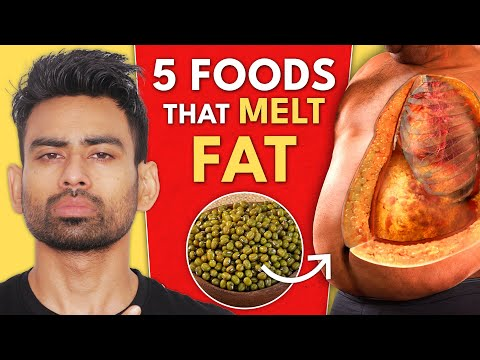


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Drinking hot water after waking up in the morning fastens bowel movements and reduces belly size.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>Drinking warm water can indeed promote bowel movements, but it's not a guaranteed remedy for constipation. While it can temporarily reduce belly size due to expelling waste, it's not a long-term weight loss solution.

• https://www.nanavatimaxhospital.org/blogs/benefits-of-drinking-hot-water.

• https://www.medicalnewstoday.com/articles/326647.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Hot water increases body temperature, activating metabolism and boosting blood circulation, which aids in weight loss.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>While hot water can temporarily increase body temperature, there's no strong evidence that this consistently boosts metabolism or blood circulation significantly enough to aid in weight loss. It's important to note that drinking hot water may contribute to hydration, which is essential for overall health.

• https://www.fastmedcare.com/the-benefits-of-drinking-hot-water/

• https://pubmed.ncbi.nlm.nih.gov/26085663/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• A 2020 study found that ginger, when given to rats, altered their gut in a way that reduced their obesity.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>The provided Google Fact Check information does not indicate whether any of the studies reviewed looked at the impact of ginger on gut health or obesity in rats. Therefore, it is impossible to confirm or deny the claim.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Amla, Aloe vera, and ginger juice combined can help melt fat and break fat loss plateaus.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>The provided information mentions that a combination of aloe vera juice, amla shots, and other beverages might be beneficial for weight loss. However, the information lacks specific evidence about the combined effectiveness of amla, aloe vera, and ginger juice in melting fat or breaking plateaus.

• https://timesofindia.indiatimes.com/life-style/health-fitness/weight-loss/from-aloe-vera-juice-to-amla-shots-10-natural-belly-fat-burning-drinks/articleshow/113422192.cms


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Amla is high in vitamin C and antioxidants, increases metabolism, burns fat, and reduces food cravings.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>Amla is indeed high in vitamin C and antioxidants, and some research suggests it might help with weight loss by promoting metabolism and reducing food cravings. However, further human studies are needed to confirm these effects.

• https://www.healthline.com/nutrition/amla-juice

• https://nutritionfacts.org/topics/amla/

• https://www.healthifyme.com/blog/amla-juice-for-weight-loss/

• https://www.bio-bean.com/does-amla-help-with-weight-loss/

• https://www.healthshots.com/healthy-eating/nutrition/eat-amla-everyday-check-5-reasons-why-you-must-place-it-on-top-of-your-priority-list-rn/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Aloe vera juice, high in fiber, reduces blood sugar levels and body fat.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>While studies show Aloe vera juice can reduce blood sugar levels in individuals with diabetes, it doesn't conclusively show it can reduce body fat. It's also worth noting that Aloe vera juice does not have a high fiber content.

• https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3857397/

• https://www.webmd.com/diet/supplement-guide-aloe-vera.

• https://www.healthline.com/nutrition/aloe-vera-for-weight-loss/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Ginger juice is a metabolism kickstarter, promotes feelings of fullness, and increases thermogenesis, making it ideal for fat burning.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>While ginger has been shown to increase the thermic effect of food (TEF), leading to increased thermogenesis and feelings of fullness, evidence regarding its direct impact on fat burning is limited and requires further research.

• https://pmc.ncbi.nlm.nih.gov/articles/PMC3408800/

• https://www.vinmec.com/eng/article/does-drinking-hot-ginger-water-lose-weight-en/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Cabbage is low in calories, high in fiber and water, and adds bulk to stool, helping to cleanse the inner system.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>Cabbage is low in calories and high in fiber and water, and its fiber content contributes to stool bulk. However, the claim that it helps to cleanse the inner system is not supported by the provided information.

• https://www.eatingwell.com/health-benefits-of-cabbage-8557536

• http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcTKPUazeDnuVob33I4vhQ_vSmsJJOO__Sb1NSMJW2-ALs9dHUf0fhd2wJjZ_iM8fo29.

• https://www.uclahealth.org/news/article/15-food-that-help-you-stay-hydrated.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Cabbage keeps hunger hormones in check, leading to decreased calorie intake.**</blockquote></font><font size='+1' color='grey'><blockquote>**UNSURE**

</blockquote></font>The provided information mentions that cabbage contains a compound that may help regulate estrogen levels, but does not explicitly state that it affects hunger hormones. While the article mentions that eggs improve hunger hormone balance, it does not connect this to a decreased calorie intake.

• https://get-base.com/blog/hormone-balancing-foods.


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Moong dal sprouts are low calorie, filling, high in protein, and ideal for fat loss.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>Moong dal sprouts are indeed low in calories and high in protein, but they are not ideal for fat loss as they can be hard to digest for some individuals. While they are filling, this may not translate to significant fat loss on its own.

• https://timesofindia.indiatimes.com/life-style/health-fitness/diet/do-sprouts-have-more-protein-than-regular-dal/photostory/94802405.cms

• https://gnrchospitals.com/blogs/5-health-benefits-of-sprouted-moong-dal.


____________________________________________________________________________________________________


In [ ]:
# For Video: 5 Amazing Foods for Fat Loss by Fit Tuber
# https://www.youtube.com/watch?v=gjYVS8m91UU

<font size='+2' color='Bisque'><blockquote>📓📓 🔍 **TRUTH SLEUTH FACT-CHECK REPORT** 🔍 📓📓</blockquote></font><font size='+2' color='white'><blockquote>**Boeing: Last Week Tonight with John Oliver (HBO)** by LastWeekTonight</blockquote></font>

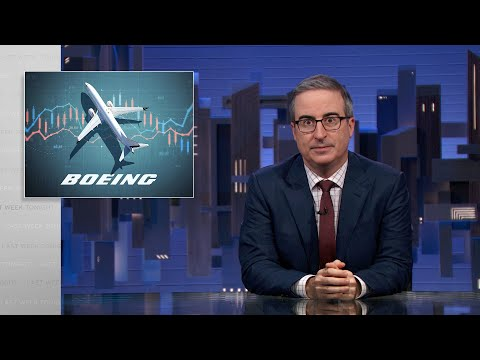


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• The 737 Max had a fatal flaw: MCAS, which could push a plane’s nose down on its own, could be activated by a single sensor.**</blockquote></font><font size='+1' color='MediumSpringGreen'><blockquote>**TRUE**

</blockquote></font>The 737 MAX was designed to mimic the pitching behavior of the previous generation of the series, the Boeing 737 NG, by pushing down the aircraft nose from an elevated angle of attack (AoA) by automatically adjusting the horizontal stabilizer and trim tab. The system was intended to protect pilots from inadvertently flying at too steep an angle, which could result in a stall. However, during certification of the MAX, Boeing requested and received permission from the FAA to remove a description of MCAS from the aircraft manual, leaving pilots unaware of the system when the airplane entered service in 2017.

• https://en.wikipedia.org/wiki/Boeing_737_MAX


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Boeing told airlines and regulators that the Max was so similar to the old 737, simulator training wouldn’t be necessary.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>Boeing did initially believe simulator training was not required because of the 737 Max’s similarities to previous models. However, the investigation into the crashes revealed that Boeing did not fully inform airlines about the MCAS system, which required pilots to undergo simulator training.

• https://en.wikipedia.org/wiki/Boeing_737_MAX


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• A faulty MCAS activation was what had doomed the Lion Air flight.**</blockquote></font><font size='+1' color='MediumSpringGreen'><blockquote>**TRUE**

</blockquote></font>The final report by the National Transportation Safety Committee concluded that the Lion Air Flight 610 crash was caused by erroneous data from a miscalibrated angle-of-attack sensor which activated the MCAS system.

• https://en.wikipedia.org/wiki/Lion_Air_Flight_610


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Boeing successfully lobbied to reduce government oversight of airplane designs, allowing them to regulate themselves even more.**</blockquote></font><font size='+1' color='LightGreen'><blockquote>**PARTLY TRUE**

</blockquote></font>Boeing was granted authority to review its own designs by the FAA, but this was not a case of Boeing regulating itself. The FAA ultimately had to certify the design and was responsible for safety oversight. Boeing was able to influence the certification process, but ultimately, the FAA remained the regulatory body.

• https://en.wikipedia.org/wiki/Boeing_737_MAX_certification


____________________________________________________________________________________________________


In [ ]:
# For Video: Boeing: Last Week Tonight with John Oliver (HBO) by LastWeekTonight
# https://www.youtube.com/watch?v=Q8oCilY4szc

<font size='+2' color='Bisque'><blockquote>📓📓 🔍 **TRUTH SLEUTH FACT-CHECK REPORT** 🔍 📓📓</blockquote></font><font size='+2' color='white'><blockquote>**Getting To Know VP Kamala Harris | Trump's FEMA Lies Harm Hurricane Victims | Elon Is So Cringe** by The Late Show with Stephen Colbert</blockquote></font>

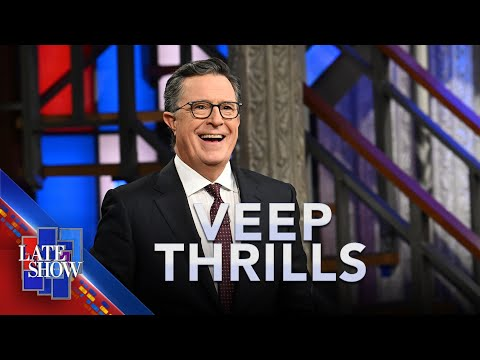


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Donald Trump falsely claimed Kamala Harris spent all FEMA money on housing illegal migrants.**</blockquote></font><font size='+1' color='MediumSpringGreen'><blockquote>**TRUE**

</blockquote></font>Multiple reliable fact-checkers have determined that Donald Trump's claim that Vice President Kamala Harris spent all FEMA money on housing illegal migrants is false. This is consistent with the fact that the Biden Administration has stated that it has no money for disaster relief due to money spent on illegal migrants, indicating that this claim is entirely unfounded.

• https://www.factcheck.org/2024/10/trumps-false-claim-of-stolen-disaster-relief-funds/

• https://www.washingtonpost.com/politics/2024/10/04/no-biden-didnt-take-fema-relief-money-use-migrants-trump-did/

• https://www.usatoday.com/story/news/factcheck/2024/10/08/fema-funding-immigrants-fact-check/75560551007/

• https://www.politifact.com/factchecks/2024/oct/08/donald-trump/biden-administration-didnt-steal-1-billion-from-fe/


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• A fake image of Donald Trump wading into floodwaters with first responders was spread online by Republicans.**</blockquote></font><font size='+1' color='MediumSpringGreen'><blockquote>**TRUE**

</blockquote></font>The provided information states that an image depicting Donald Trump wading through floodwaters to rescue people was circulated online after Hurricane Helene, despite Trump not performing any hands-on relief work. The passage also mentions that Republicans spread the image as evidence of the Biden administration's failures in responding to the disaster.

• https://en.wikipedia.org/wiki/Conspiracy_theories_about_the_2024_Atlantic_hurricane_season


____________________________________________________________________________________________________
<font size='+1' color='white'><blockquote>**• Kamala Harris attended law school at the University of California, Hastings College of the Law in San Francisco.**</blockquote></font><font size='+1' color='MediumSpringGreen'><blockquote>**TRUE**

</blockquote></font>The claim is true. The Wikipedia entry on the University of California College of the Law, San Francisco (formerly University of California, Hastings College of the Law) lists Kamala Harris as a notable alumna.  The provided Wikipedia summary does not include any contradicting information.

• https://en.wikipedia.org/wiki/University_of_California_College_of_the_Law,_San_Francisco


____________________________________________________________________________________________________


In [ ]:
# For Video: Getting To Know VP Kamala Harris | Trump's FEMA Lies Harm Hurricane Victims | Elon Is So Cringe by The Late Show with Stephen Colbert
# https://www.youtube.com/watch?v=6krLggTyfm4